In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import h5py
import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

from torchvision import transforms
from torch.utils import data
from sklearn.model_selection import KFold

datadir = ""
training_set = datadir + 'DR12Q-63000.h5'


In [2]:
f = h5py.File(training_set, 'r') 
f.keys()

<KeysViewHDF5 ['FLUX', 'PLATE_F', 'PLATE_T', 'Z_DR12Q_VI', 'Z_PCA', 'Z_PIPE', 'Z_QN']>

In [3]:
flux = f['FLUX'][()]  
Z_VI = f['Z_DR12Q_VI'][()]
Z_QN= f['Z_QN'][()]
Z_PIPE= f['Z_PIPE'][()]
Z_PCA= f['Z_PCA'][()]



In [4]:
#features = torch.Tensor(X).view(-1,4000)
#labels = torch.Tensor(Y).view(-1,1)

label_std = (Z_VI.std()**1.0) 
label_mean = Z_VI.mean() 
labels_norm = (Z_VI - label_mean)/label_std

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(flux ,labels_norm, test_size= 0.1,random_state = 42 )
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(flux ,Z_QN, test_size= 0.1,random_state = 42 )
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(flux ,Z_PIPE, test_size= 0.1,random_state = 42 )
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(flux ,Z_PCA, test_size= 0.1,random_state = 42 )

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train ,Y_train, test_size= 0.14,random_state = 42 )

In [7]:
from skorch.helper import predefined_split
from skorch.dataset import Dataset

X_train=torch.Tensor(X_train).view(-1,2000)
Y_train=torch.Tensor(Y_train).view(-1,1)
X_test=torch.Tensor(X_test).view(-1,2000)
Y_test=torch.Tensor(Y_test).view(-1,1)

Y_test1=torch.Tensor(Y_test1).view(-1,1)
Y_test2=torch.Tensor(Y_test2).view(-1,1)
Y_test3=torch.Tensor(Y_test3).view(-1,1)

X_valid=torch.Tensor(X_valid).view(-1,2000)
Y_valid=torch.Tensor(Y_valid).view(-1,1)


valid_ds = Dataset(X_valid, Y_valid)




In [8]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 60, 200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(60, 70,200),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(70, 36, 32),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Sequential(
            nn.Linear(5724, 900),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(900, 100),
            nn.ReLU())
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [9]:
model= FNet()
print(model)

FNet(
  (layer1): Sequential(
    (0): Conv1d(1, 60, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(60, 70, kernel_size=(200,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv1d(70, 36, kernel_size=(32,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=5724, out_features=900, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=900, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


In [10]:
from skorch import NeuralNet
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import StepLR


net1 = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =75,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.00014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net1.fit(X_train,Y_train)
net2 = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =10,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.000014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net2.fit(X_train,Y_train)
net3 = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =5,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.0000014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net3.fit(X_train,Y_train)
net = NeuralNet(model,
               criterion =nn.MSELoss,
               max_epochs =3,
               batch_size=100,
                optimizer=torch.optim.Adam,
                optimizer__lr =0.00000014,#=0.00011,=0.000051,=0.000001,=0.0000001
                optimizer__weight_decay=1e-5,#0.00005,
                #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1),
                #optimizer__epsilon=1e-08,
                #optimizer__alpha=0.1,
                train_split=predefined_split(valid_ds),
                optimizer__betas=(0.9, 0.999),
               device ='cuda') 
net.fit(X_train,Y_train)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.1754        0.0643  128.5471
      2        0.0490        0.0314  130.6459
      3        0.0312        0.0294  131.1824
      4        0.0252        0.0261  131.2021
      5        0.0201        0.0190  131.1994
      6        0.0168        0.0155  131.1955
      7        0.0144        0.0151  131.1706
      8        0.0136        0.0140  131.1364
      9        0.0127        0.0140  131.0896
     10        0.0114        0.0129  131.0844
     11        0.0107        0.0137  131.0957
     12        0.0101        0.0130  131.0757
     13        0.0084        0.0105  131.0612
     14        0.0091        0.0108  131.0660
     15        0.0085        0.0126  131.0185
     16        0.0077        0.0121  131.0084
     17        0.0084        0.0156  130.9776
     18        0.0070        0.0131  130.9591
     19        0.0059        0.0106  130.9163
     20        0.0071        0.009

<class 'skorch.net.NeuralNet'>[initialized](
  module_=FNet(
    (layer1): Sequential(
      (0): Conv1d(1, 60, kernel_size=(200,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(60, 70, kernel_size=(200,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv1d(70, 36, kernel_size=(32,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (drop_out): Dropout(p=0.5, inplace=False)
    (fc1): Sequential(
      (0): Linear(in_features=5724, out_features=900, bias=True)
      (1): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_features=900, out_features=100, bias=True)
      (1): ReLU()
    )
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  ),
)

In [11]:
valid_loss_1 = net1.history[:,'valid_loss']
valid_loss_2 = net2.history[:,'valid_loss']
valid_loss_3 = net3.history[:,'valid_loss']
valid_loss = net.history[:,'valid_loss']


In [29]:
train_loss_1 = net1.history[:,'train_loss'] 
train_loss_2 = net2.history[:,'train_loss']    
train_loss_3 = net3.history[:,'train_loss']   
train_loss = net.history[:,'train_loss']


In [35]:
trainloss=np.concatenate((train_loss_1,train_loss_2,train_loss_3,train_loss), axis=0)
validloss=np.concatenate((valid_loss_1,valid_loss_2,valid_loss_3,valid_loss), axis=0)

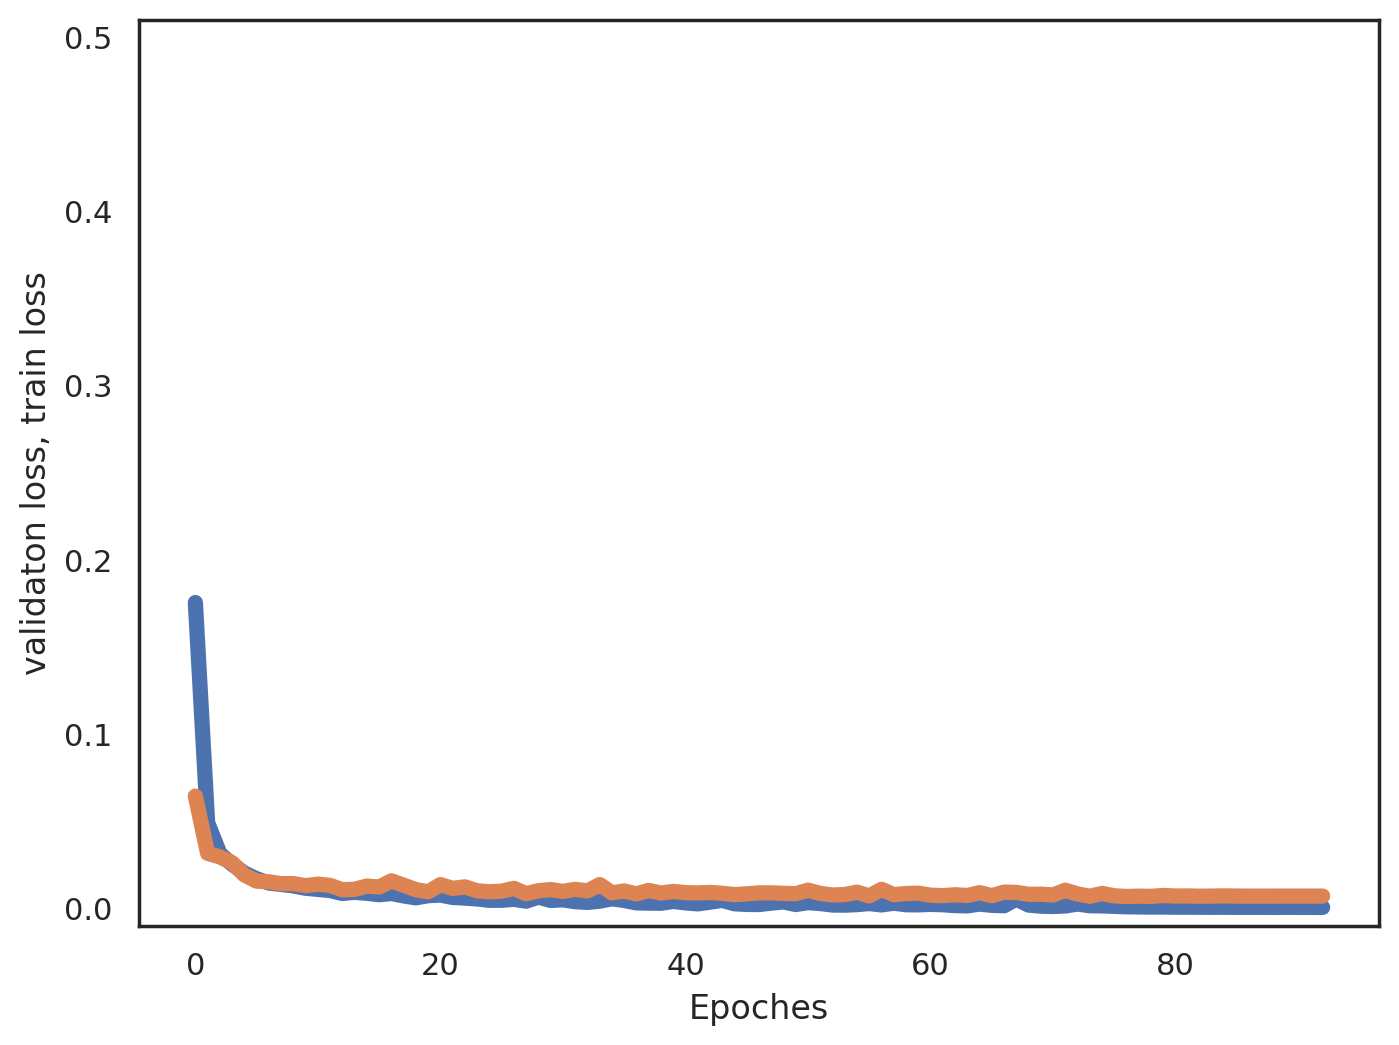

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.xlabel('Epoches')
plt.ylabel('validaton loss, train loss')
plt.plot(trainloss,linewidth=5.5)
plt.plot(validloss,linewidth=5.5)
#plt.xlim(0.1,7.1)
plt.ylim(-0.01,0.51)
plt.show()

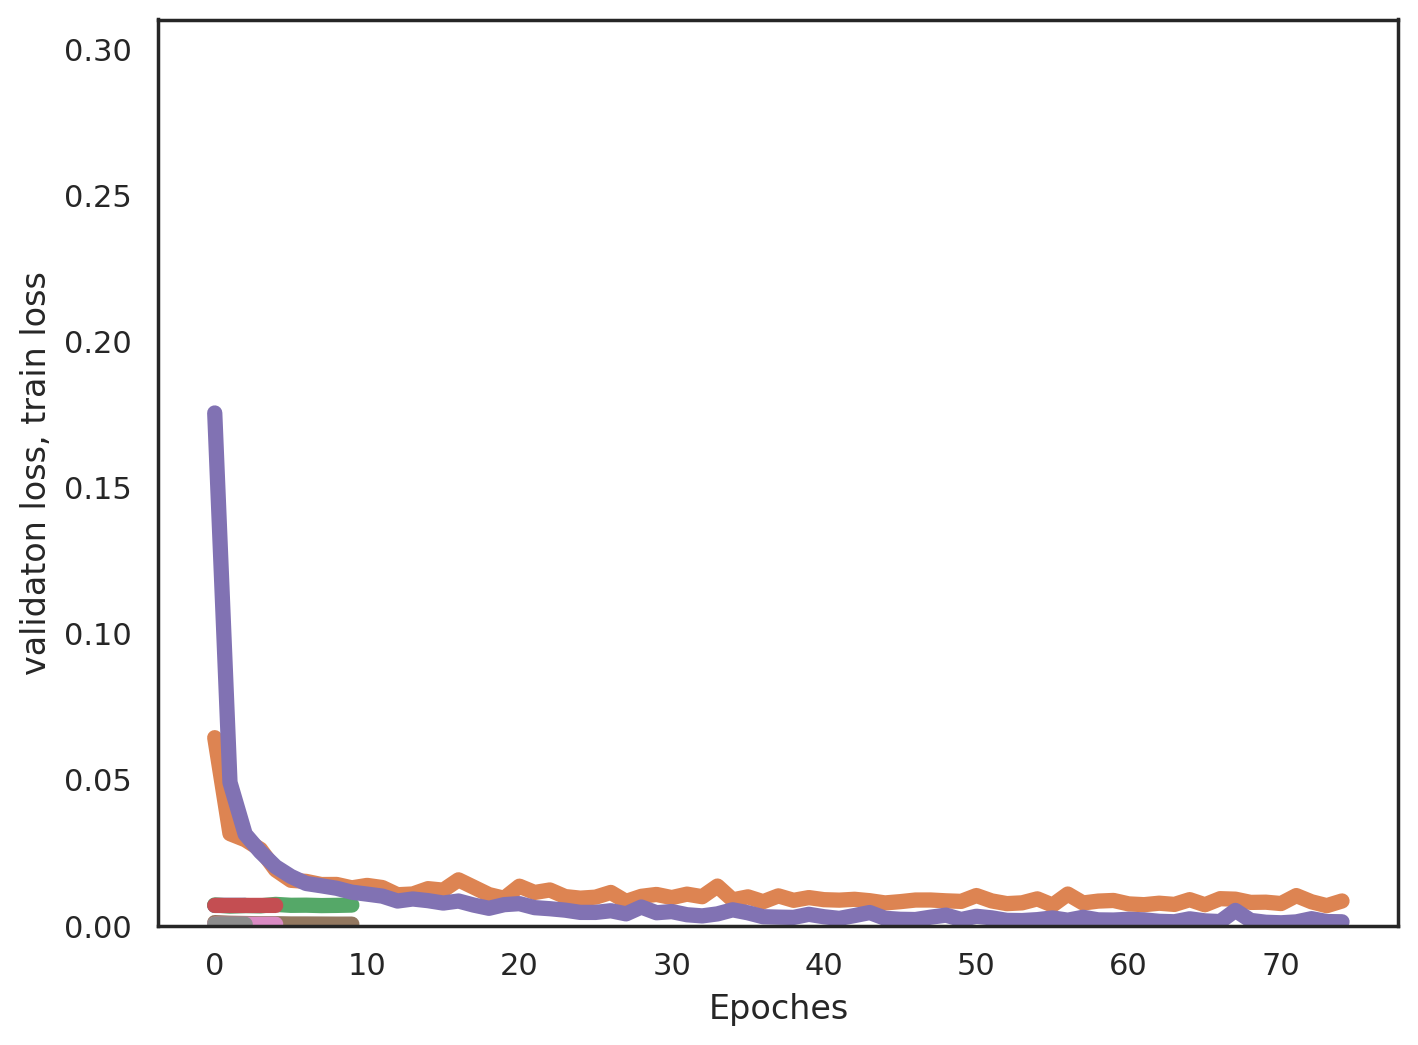

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.xlabel('Epoches')
plt.ylabel('validaton loss, train loss')
plt.plot(valid_loss,linewidth=5.5)
plt.plot(valid_loss_1,linewidth=5.5)
plt.plot(valid_loss_2,linewidth=5.5)
plt.plot(valid_loss_3,linewidth=5.5)
plt.plot(train_loss_1,linewidth=5.5)
plt.plot(train_loss_2,linewidth=5.5)
plt.plot(train_loss_3,linewidth=5.5)
plt.plot(train_loss,linewidth=5.5)
#plt.xlim(0.1,7.1)
plt.ylim(0.0,0.31)
plt.show()

In [15]:
Y_pred = net.predict(X_test)


<Figure size 1000x700 with 0 Axes>

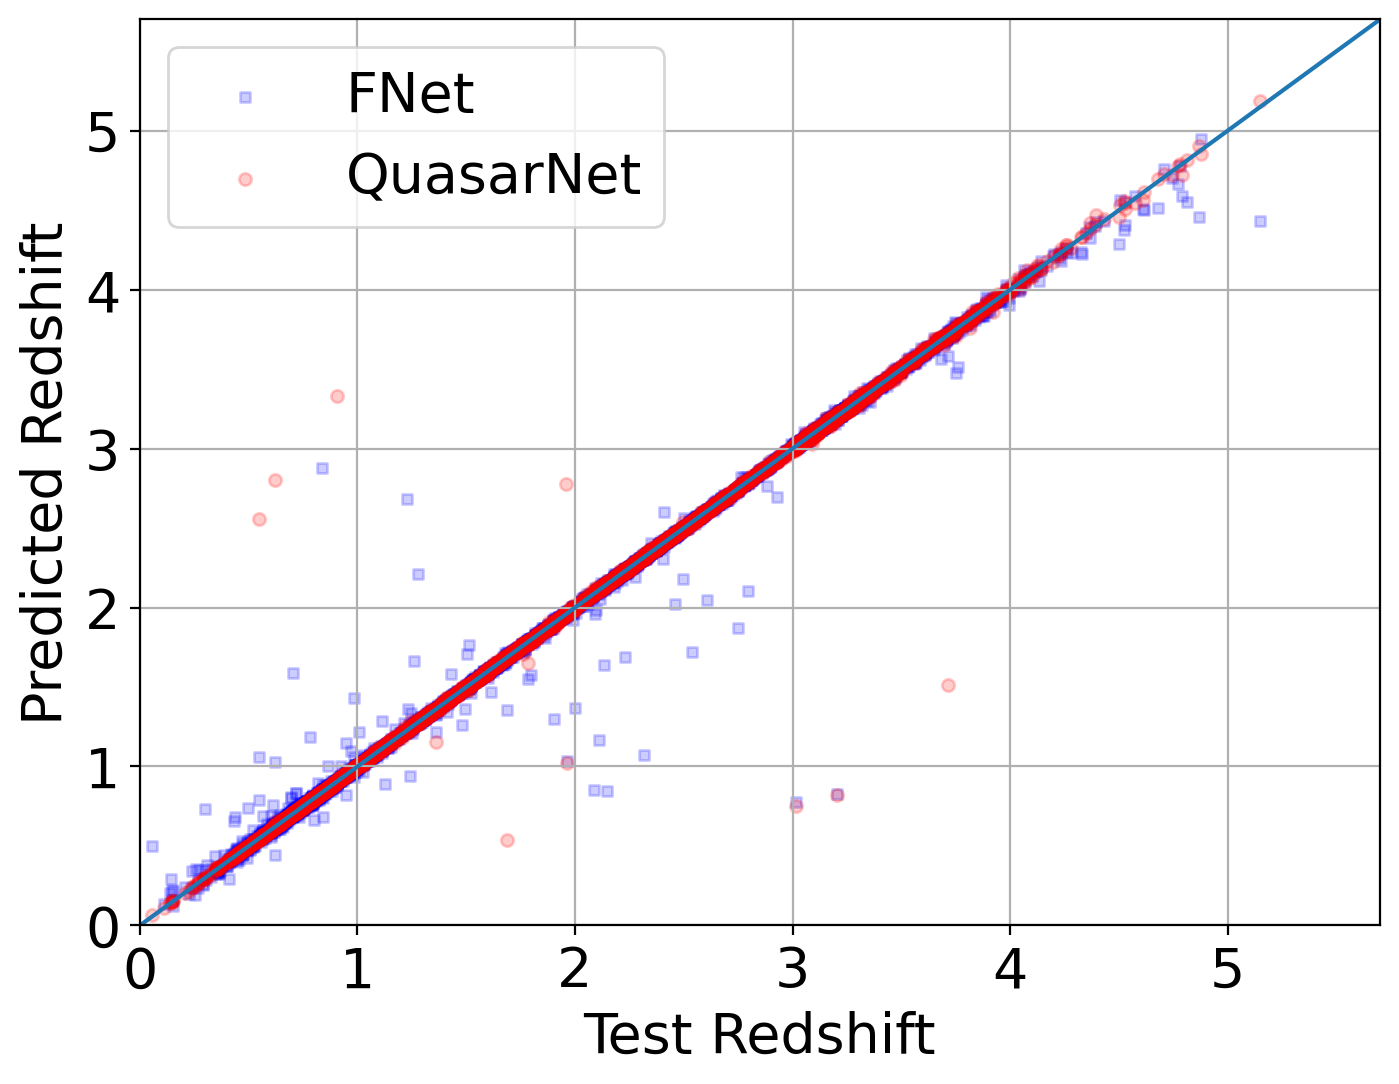

In [17]:
import matplotlib.pyplot as plt
#labels_norm = (Y - label_mean)/label_std

Z = Y_pred*label_std+label_mean
y = Y_test*label_std+label_mean

plt.figure(figsize=(10,7))

x1=np.linspace(0,5.7,9)
y1=x1
y2=(1+x1)/10 +x1
y3=-(1+x1)/10 +x1

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y, Z, s=15, c='b', marker="s",label='FNet',alpha=0.2)
ax1.scatter(y, Y_test1, s=20, c='r', marker="o",label='QuasarNet',alpha=0.2)
plt.plot(x1,y1)
#plt.plot(x1,y2)
#plt.plot(x1,y3)
plt.legend(fontsize=20)
plt.xlabel('Test Redshift', fontsize=20)
plt.ylabel('Predicted Redshift', fontsize=20)
plt.xlim(0.0,5.7)
plt.ylim(0.0,5.7)
plt.yticks(fontsize=20) 
plt.xticks(fontsize=20) 
plt.grid()
plt.show()

In [18]:
REL=300000*(Z-y.numpy())/(1+y.numpy())
REL1=300000*(Y_test1.numpy()-y.numpy())/(1+y.numpy())
REL2=300000*(Y_test2.numpy()-y.numpy())/(1+y.numpy())
REL3=300000*(Y_test3.numpy()-y.numpy())/(1+y.numpy())
print(abs(REL).mean(),REL.mean())

1543.4183982198665 17.26937204005095


In [19]:
for i in range(len(REL1)):
    if ((abs(REL[i])>30000)):
        print(y.numpy()[i],Y_test1[i],Z[i], file=open("Error1.txt", "a"))

In [20]:
for i in range(len(REL1)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))

In [21]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((y.numpy()[i]>2.0)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines()))

3273


In [22]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.9771790808240888


In [23]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL1[i])<12000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.998256735340729


In [24]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL2[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.9868462757527734


In [25]:
file = open('Rahim.txt', "r+")
file.truncate()
for i in range(len(REL)):
    if ((abs(REL3[i])<6000)):
        print(i, file=open("Rahim.txt", "a"))
        
with open("Rahim.txt","r") as f:
    print(len(f.readlines())/len(REL))

0.9992076069730587


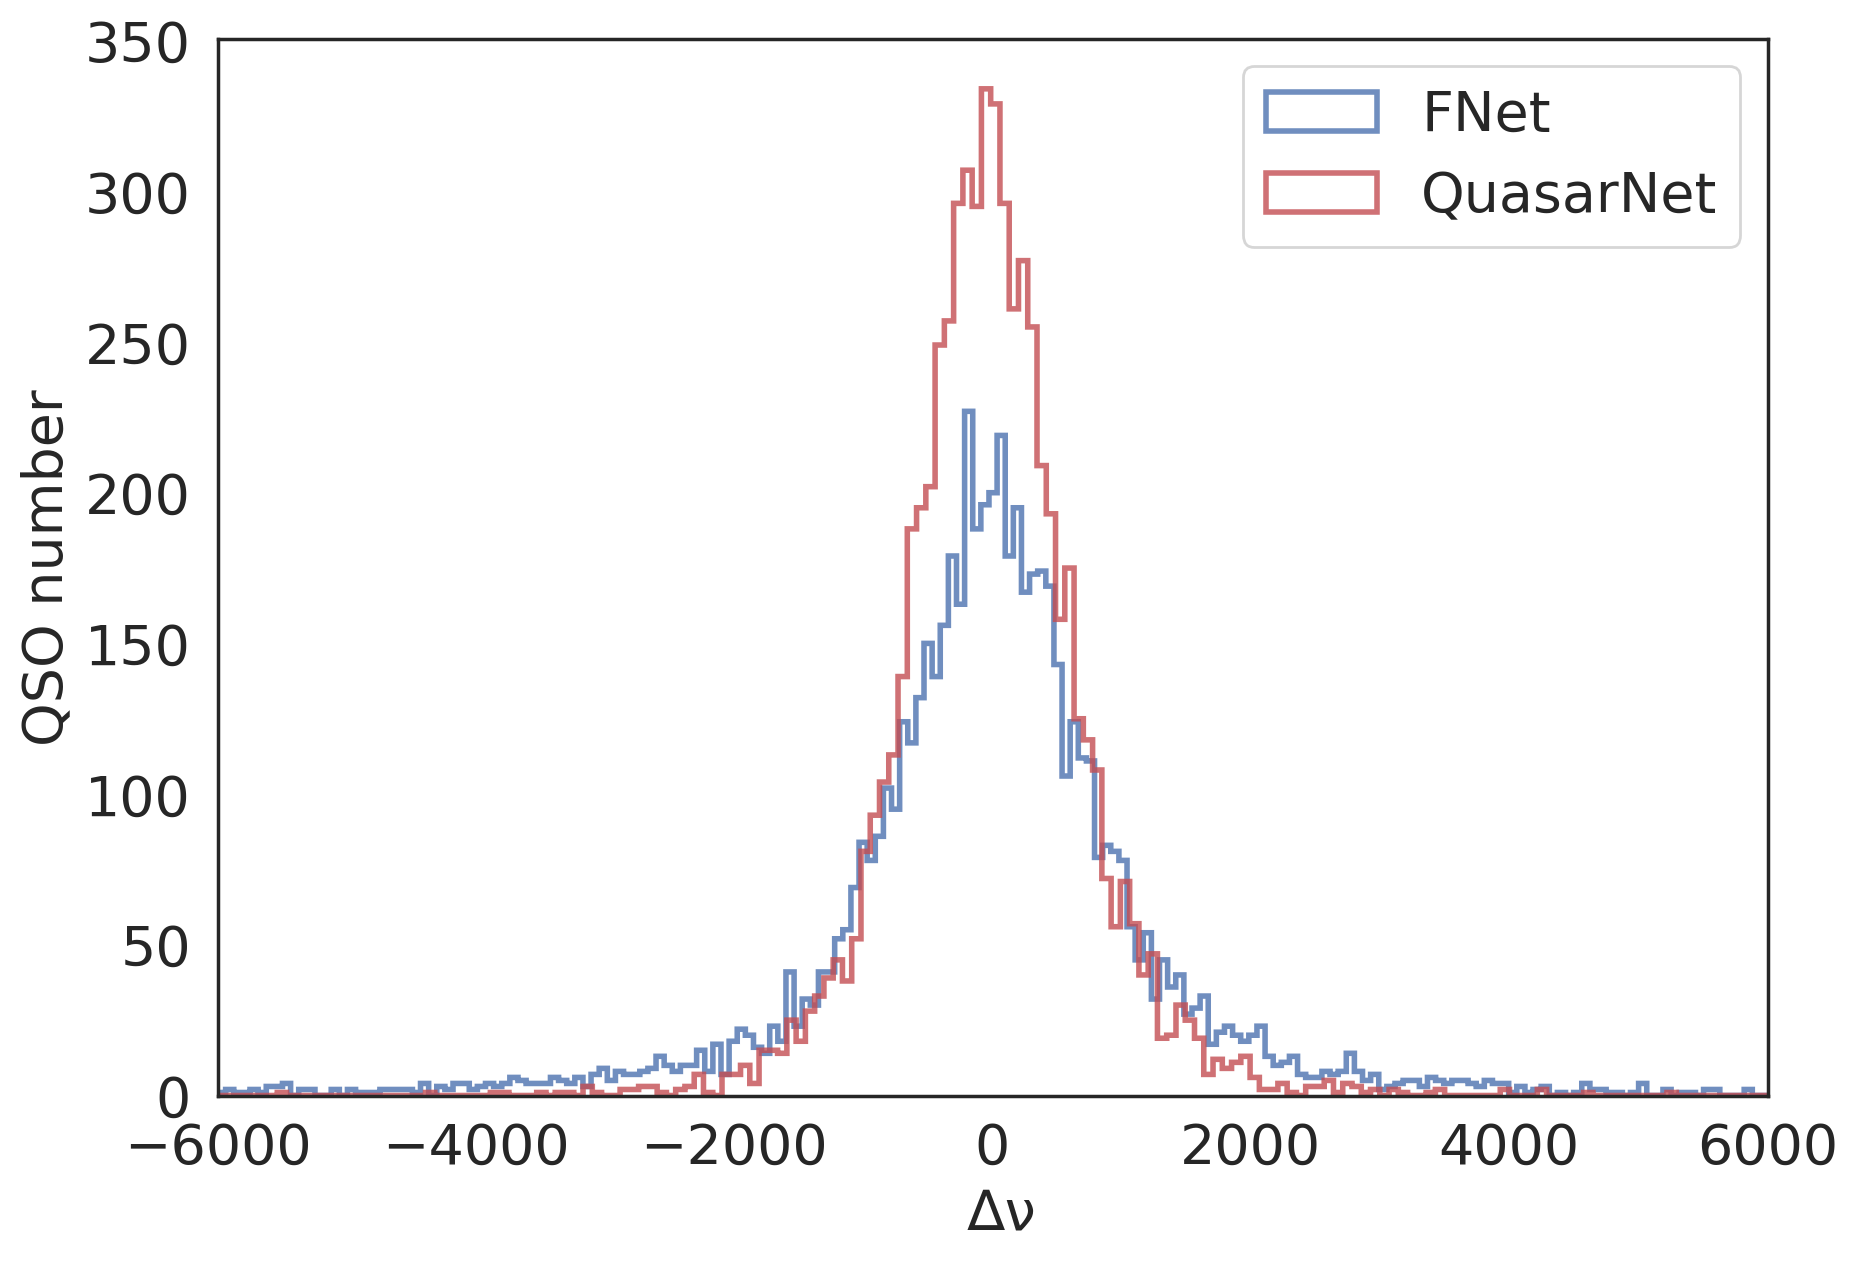

In [26]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
#pyplot.yscale('log')
data = REL
plt.figure(figsize=(10,7))

sns.set_style('white')

plt.hist(data, bins=8000,histtype='step',alpha=0.8,edgecolor='b',linewidth=2,label='FNet')
plt.hist(REL1, bins=8000,histtype='step',alpha=0.8,edgecolor='r',linewidth=2,label='QuasarNet')
#plt.hist(REL2, bins=6000,histtype='step',alpha=0.3,edgecolor='g',linewidth=2,label='ZPIPW')
#plt.hist(REL3, bins=9000,histtype='step',alpha=0.3,edgecolor='black',linewidth=2,label='PCA')

plt.ylabel('QSO number', fontsize=20)
plt.yticks(fontsize=20) 

plt.xlabel(' ∆ν', fontsize=20)
plt.xticks(fontsize=20) 


plt.xlim(-6000,6000)
plt.legend(loc='best', fontsize=20) 
#plt.ylim(0,7)
plt.savefig('FNet.pdf')
plt.show() 
